In [1]:
import os
#changing the working directory to the current file location
os.chdir('/research/dept8/gds/zjxu21/TGTSF')

In [3]:
import torch
import torch.nn as nn
import numpy as np
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear, PatchTST, TGTSF_PatchTST, TTSF, TGTSF_torch
from data_provider.data_factory import TGTSF_data_provider, TGTSF_weather_data_provider
from utils.tools import EarlyStopping, adjust_learning_rate, visual, test_params_flop
import tempfile
import time
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred, Dataset_TGTSF, Dataset_TGTSF_elec, Dataset_TGTSF_weather


# from ray.train import Checkpoint

# from ray import train

from matplotlib import pyplot as plt
import json

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
config = {
    "root_path": './dataset/Weather_captioned',
    "data_path": 'weather_2014-18.parquet',
    'news_path': 'caption_emb',
    'des_path': 'caption_emb',
    "info_overhead": 0,
    "news_pre_embed": 1,
    "des_pre_embed": 1,
    "add_date": 1,
    "text_dim": 512,
    "cross_layers": 3,
    "mixer_self_layers": 2,
    "model_id": 'weather_288_96',  # Assuming variables are defined
    "model": 'weather_tune',  # Assuming variable is defined
    "data": 'weather',  # Assuming variable is defined
    "features": "M",
    "seq_len": 288,  # Assuming variable is defined
    "pred_len": 720,  # Assuming variable is defined
    "enc_in": 1,
    "e_layers": 3,
    "n_heads": 16,
    "d_model": 512,
    "d_ff": 256,
    "dropout": 0.2,
    "fc_dropout": 0.2,
    "head_dropout": 0,
    "num_workers": 2,
    "patch_len": 6,
    "stride": 6,
    "des": "Exp",
    "train_epochs": 100,
    "patience": 20,
    "target": "Channel 1",
    "lradj": "TST",
    "pct_start": 0.1,
    "itr": 1,
    "batch_size": 1,  # Assuming variable is defined
    "learning_rate": 0.0001,
    # "target_ckpt": 'checkpoints/0410_104952_weather_288_720_TGTSF_torch_weather_ftM_sl288_ll48_pl720_dm512_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_Exp_0'
    "target_ckpt": 'checkpoints/0418_160928_weather_288_720_TGTSF_torch_weather_ftM_sl288_ll48_pl720_dm512_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_Exp_0'
}

config = dotdict(config)

In [5]:
# better ckpt no rin
config = {
    "root_path": './dataset/Weather_captioned',
    "data_path": 'weather_2014-18.parquet',
    'news_path': 'caption_emb',
    'des_path': 'caption_emb',
    "info_overhead": 0,
    "news_pre_embed": 1,
    "des_pre_embed": 1,
    "add_date": 1,
    "text_dim": 512,
    "cross_layers": 3,
    "mixer_self_layers": 2,
    "model_id": 'weather_288_96',  # Assuming variables are defined
    "model": 'weather_tune',  # Assuming variable is defined
    "data": 'weather',  # Assuming variable is defined
    "features": "M",
    "seq_len": 288,  # Assuming variable is defined
    "pred_len": 720,  # Assuming variable is defined
    "enc_in": 1,
    "e_layers": 3,
    "n_heads": 16,
    "d_model": 512,
    "d_ff": 256,
    "dropout": 0.2,
    "fc_dropout": 0.2,
    "head_dropout": 0,
    "num_workers": 2,
    "patch_len": 6,
    "stride": 3,
    "des": "Exp",
    "train_epochs": 100,
    "patience": 20,
    "target": "Channel 1",
    "lradj": "TST",
    "pct_start": 0.1,
    "itr": 1,
    "batch_size": 1,  # Assuming variable is defined
    "learning_rate": 0.0001,
    'revin': 0,
    "target_ckpt": 'checkpoints/0418_160928_weather_288_720_TGTSF_torch_weather_ftM_sl288_ll48_pl720_dm512_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_Exp_0'
}

config = dotdict(config)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TGTSF_torch.Model(config).float().to(device)
criterion = nn.MSELoss()
model.load_state_dict(torch.load(os.path.join('./' + config.target_ckpt, 'checkpoint.pth')))

<All keys matched successfully>

In [7]:
test_data = Dataset_TGTSF_weather(
        root_path=config.root_path,
        data_path=config.data_path,
        news_path=config.news_path,
        des_path=config.des_path,
        flag='test',
        size=[config.seq_len, 2, config.pred_len],
        features=config.features,
        target=config.target,
        info_overhead=config.info_overhead,
        news_pre_embed=config.news_pre_embed,
        des_pre_embed=config.des_pre_embed,
        text_encoder=None,
        add_date=config.add_date,
        text_dim=config.text_dim,
        scale=True,
        stride = config.stride, # disable the individual norm
        control=True
    )

# def get_data(flag):
#     data_set, data_loader = TGTSF_weather_data_provider(config, flag)
#     return data_set, data_loader
# test_data, test_loader = get_data(flag='test')

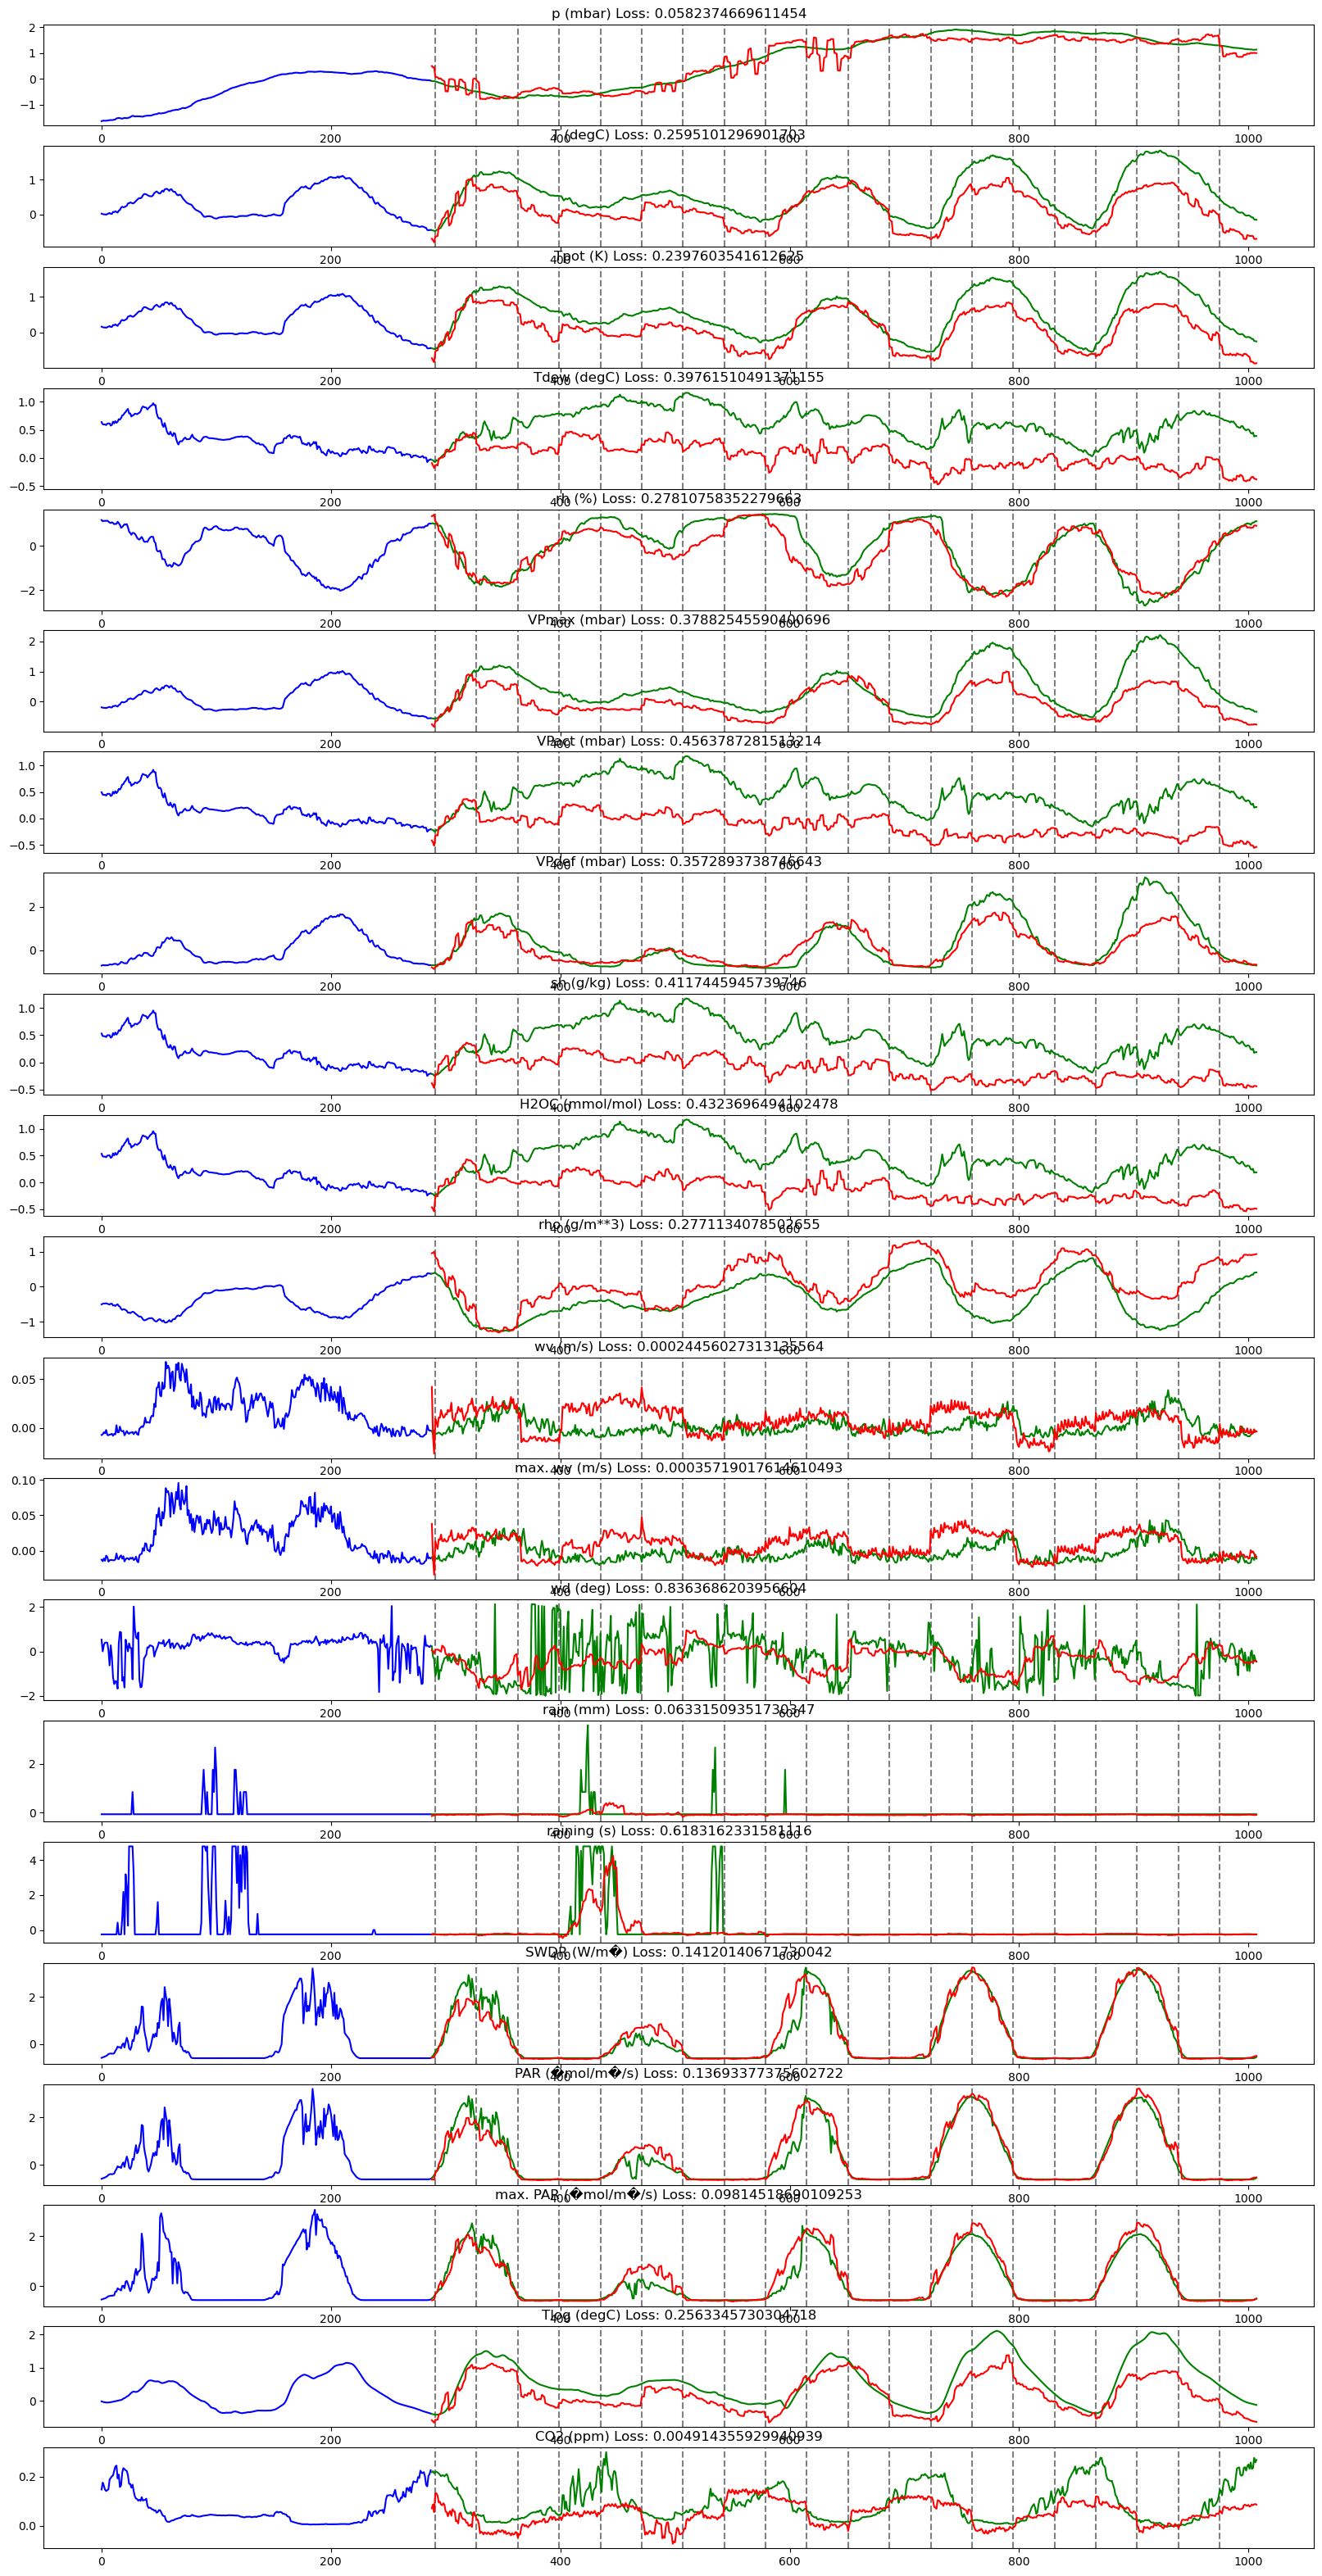

In [16]:
%matplotlib inline
from torch.nn.utils.rnn import pad_sequence

    
index = 15000#15000#25000 mean bias#10000 generaly good#1500 wind_dir
batch_x, batch_y, batch_news, batch_des, time_stamps = test_data[index]
batch_x = torch.tensor(batch_x).unsqueeze(0).float()
batch_y = torch.tensor(batch_y).unsqueeze(0).float()

batch_news = batch_news.float().unsqueeze(0)
batch_des = batch_des.float().unsqueeze(0)
# news_mask = news_mask.float().to(device)
max_len = max([tensor.shape[1] for tensor in batch_news])
# print('padding to', max_len)
masks = []

for i in range(len(batch_news)):
    mask = torch.cat((torch.zeros((batch_news[i].shape[0], batch_news[i].shape[1])), torch.ones((batch_news[i].shape[0], max_len - batch_news[i].shape[1]))), dim=1)
    batch_news[i] = torch.cat((batch_news[i], torch.zeros((batch_news[i].shape[0], max_len - batch_news[i].shape[1], batch_news[i].shape[2]))), dim=1)
    #  create a mask matrix for the news. set it as 1 where all the elements on dimension 3 of the batch_news are all 0
    # mask = (batch_news[i].sum(dim=2) == 0)
    masks.append(mask)
mask = pad_sequence(masks, batch_first=True, padding_value=0)
news_mask = mask.float().to(device)
batch_x = batch_x.to(device)
batch_y = batch_y
batch_news = batch_news.to(device)
batch_des = batch_des.to(device)

outputs = model(batch_x, batch_news, batch_des, news_mask)



preds = outputs.detach().cpu()
trues = batch_y.detach()
inputs = batch_x.detach().cpu()

# create a figure with (12, 2) subplots
fig, axs = plt.subplots(21, 1, figsize=(20, 40))

cols=test_data.cols[-outputs.shape[2]:]

change_points=[]

for i in range(batch_news.shape[1]-1):
    if (batch_news[0][i+1][0]-batch_news[0][i][0]).sum() != 0:
        change_points.append(i+1)

for dim in range(outputs.shape[2]):
    pred = preds[0, -config.pred_len:, dim]
    true = trues[0, -config.pred_len:, dim]
    input = inputs[0, :, dim]

    loss = criterion(pred, true)

    # select subplot 3
    for change_point in change_points:
        axs[dim].axvline(x=change_point*3+288, color='grey', linestyle='--')

    # plot the concatenated input, prediction and true values
    axs[dim].plot(np.arange(len(input)), input, label='input', color='blue')
    axs[dim].plot(np.arange(len(input), len(input) + len(true)), true, label='true', color='green')
    axs[dim].plot(np.arange(len(input), len(input) + len(pred)), pred, label='pred', color='red')
    axs[dim].set_title(f'{cols[dim]} Loss: {loss.item()}')

    


# show the plot
plt.show()

## Control test

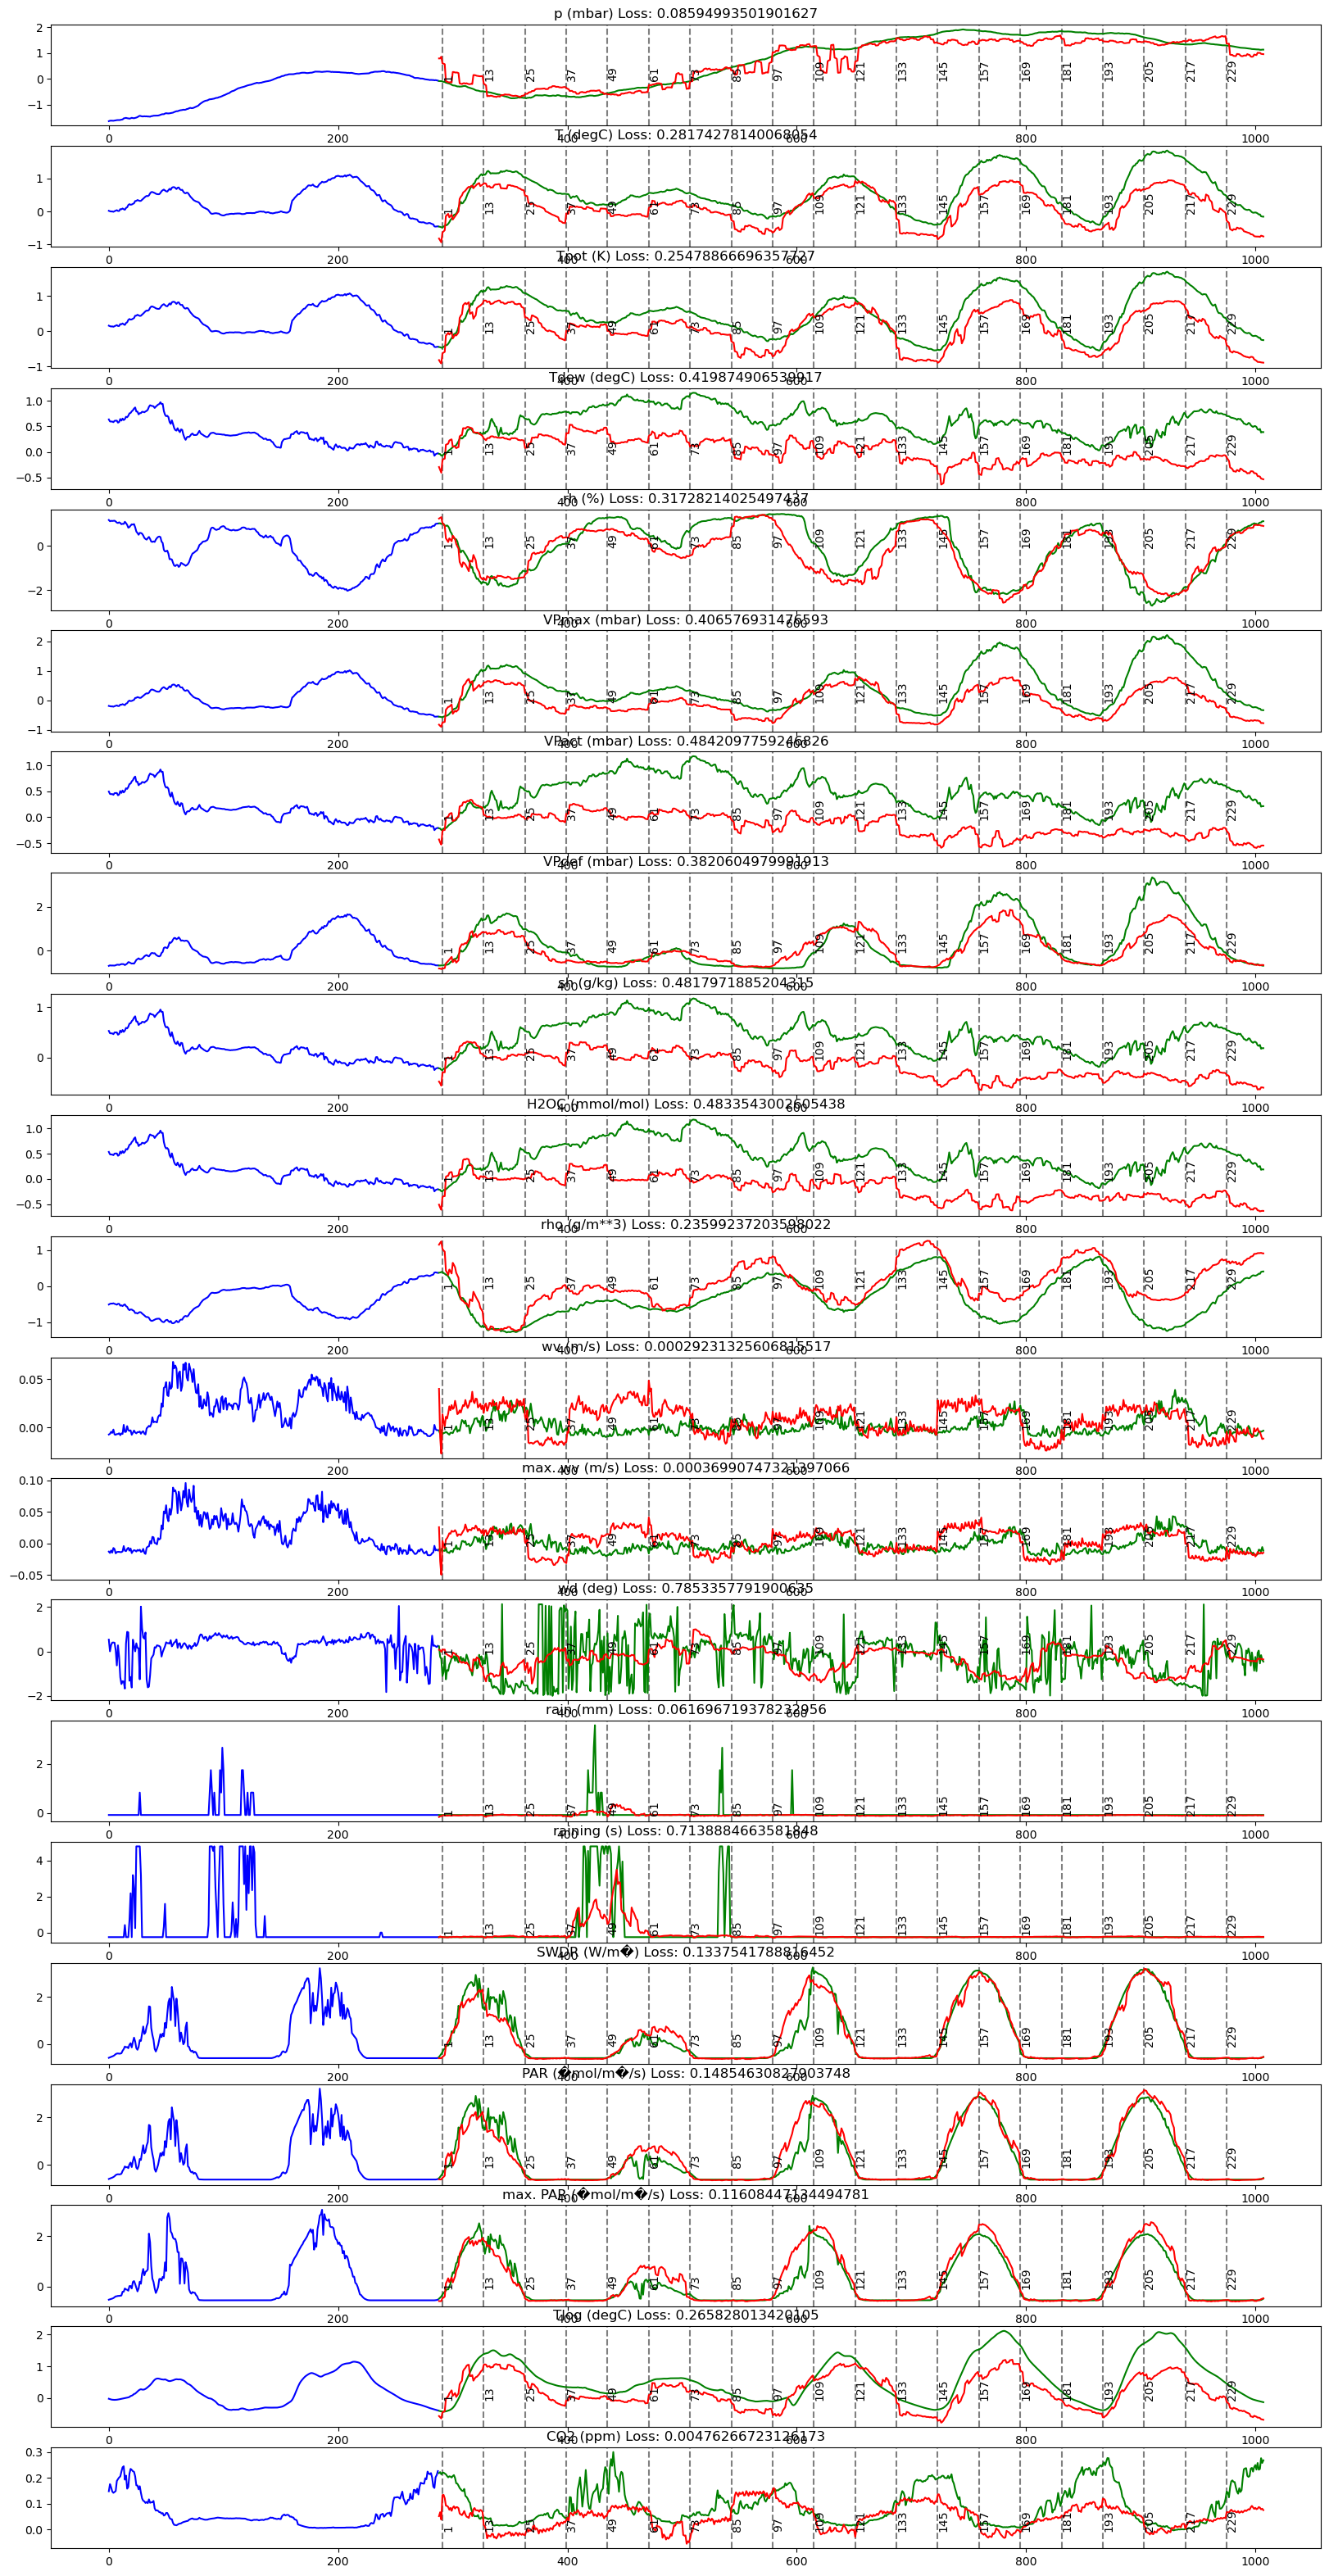

In [22]:
%matplotlib inline
from torch.nn.utils.rnn import pad_sequence

    
index = 15000
batch_x, batch_y, batch_news, batch_des, time_stamps = test_data[index]
batch_x = torch.tensor(batch_x).unsqueeze(0).float()
batch_y = torch.tensor(batch_y).unsqueeze(0).float()

batch_news = batch_news.float().unsqueeze(0)
batch_des = batch_des.float().unsqueeze(0)
# news_mask = news_mask.float().to(device)
max_len = max([tensor.shape[1] for tensor in batch_news])
# print('padding to', max_len)
masks = []

for i in range(len(batch_news)):
    mask = torch.cat((torch.zeros((batch_news[i].shape[0], batch_news[i].shape[1])), torch.ones((batch_news[i].shape[0], max_len - batch_news[i].shape[1]))), dim=1)
    batch_news[i] = torch.cat((batch_news[i], torch.zeros((batch_news[i].shape[0], max_len - batch_news[i].shape[1], batch_news[i].shape[2]))), dim=1)
    #  create a mask matrix for the news. set it as 1 where all the elements on dimension 3 of the batch_news are all 0
    # mask = (batch_news[i].sum(dim=2) == 0)
    masks.append(mask)
mask = pad_sequence(masks, batch_first=True, padding_value=0)
news_mask = mask.float().to(device)
batch_x = batch_x.to(device)
batch_y = batch_y
batch_news = batch_news.to(device)
batch_des = batch_des.to(device)

outputs = model(batch_x, batch_news, batch_des, news_mask)



preds = outputs.detach().cpu()
trues = batch_y.detach()
inputs = batch_x.detach().cpu()

# create a figure with (12, 2) subplots
fig, axs = plt.subplots(21, 1, figsize=(20, 40))

cols=test_data.cols[-outputs.shape[2]:]

change_points=[]

for i in range(batch_news.shape[1]-1):
    if (batch_news[0][i+1][0]-batch_news[0][i][0]).sum() != 0:
        change_points.append(i+1)

for dim in range(outputs.shape[2]):
    pred = preds[0, -config.pred_len:, dim]
    true = trues[0, -config.pred_len:, dim]
    input = inputs[0, :, dim]

    loss = criterion(pred, true)

    # select subplot 3
    for change_point in change_points:
        axs[dim].axvline(x=change_point*3+288, color='grey', linestyle='--')
        # add the change_point as a text aside the axvline
        axs[dim].text(change_point*3+288, 0, f'{change_point}', rotation=90)

    # plot the concatenated input, prediction and true values
    axs[dim].plot(np.arange(len(input)), input, label='input', color='blue')
    axs[dim].plot(np.arange(len(input), len(input) + len(true)), true, label='true', color='green')
    axs[dim].plot(np.arange(len(input), len(input) + len(pred)), pred, label='pred', color='red')
    axs[dim].set_title(f'{cols[dim]} Loss: {loss.item()}')

    


# show the plot
plt.show()

In [35]:
# get the timestamp of a segment
time_stamp=time_stamps[37]
date = str(time_stamp)[:8]
time = int(str(time_stamp)[8:])
if time<=559:
    time_stamp=date+'0000'
elif time<=1159:
    time_stamp=date+'0600'
elif time<=1759:
    time_stamp=date+'1200'
else:
    time_stamp=date+'1800'
time_stamp

'201804160000'

In [19]:
class Translator(object):
    def __init__(self, codebookpath, embeddingdict) -> None:
        with open(codebookpath, 'r') as f:
            self.mapping = json.load(f)
        self.mapping = {v:k for k, v in self.mapping.items()}
        self.embeddingdict = embeddingdict
    def __getitem__(self, key):
        if isinstance(key, list):
            return [self.mapping[k] for k in key], [self.embeddingdict[k] for k in key] # translate the hash back to text and embedding
        return self.mapping[key], self.embeddingdict[key]

trans = Translator(os.path.join(config.root_path, 'hashtable.json'), test_data.msg2emb) # get a translator object

In [34]:
# replace the news with other news according to the given time. Can run this cell multiple times to replace multiple segments

# get the mapping of a time stamp
tgt_time_stamp = '201804181800'
segment_start = 37

sentences, embeddings=trans[test_data.time2msg[1][tgt_time_stamp]]
print(sentences)
# replace the segment with other news
batch_news[0][segment_start:segment_start+12][:, 1:] = torch.stack(embeddings[1:], dim=0)

["It's the evening of a day in April. ", 'The current weather is clear. ', 'The weather is expected to be clear due to the absence of detailed changes. ', 'The temperature is within comfortable range, though specifics are not detailed. ', 'There is Light Breeze from ENE. ', 'The atmospheric shows Very High Pressure.', 'The humidity is average.']


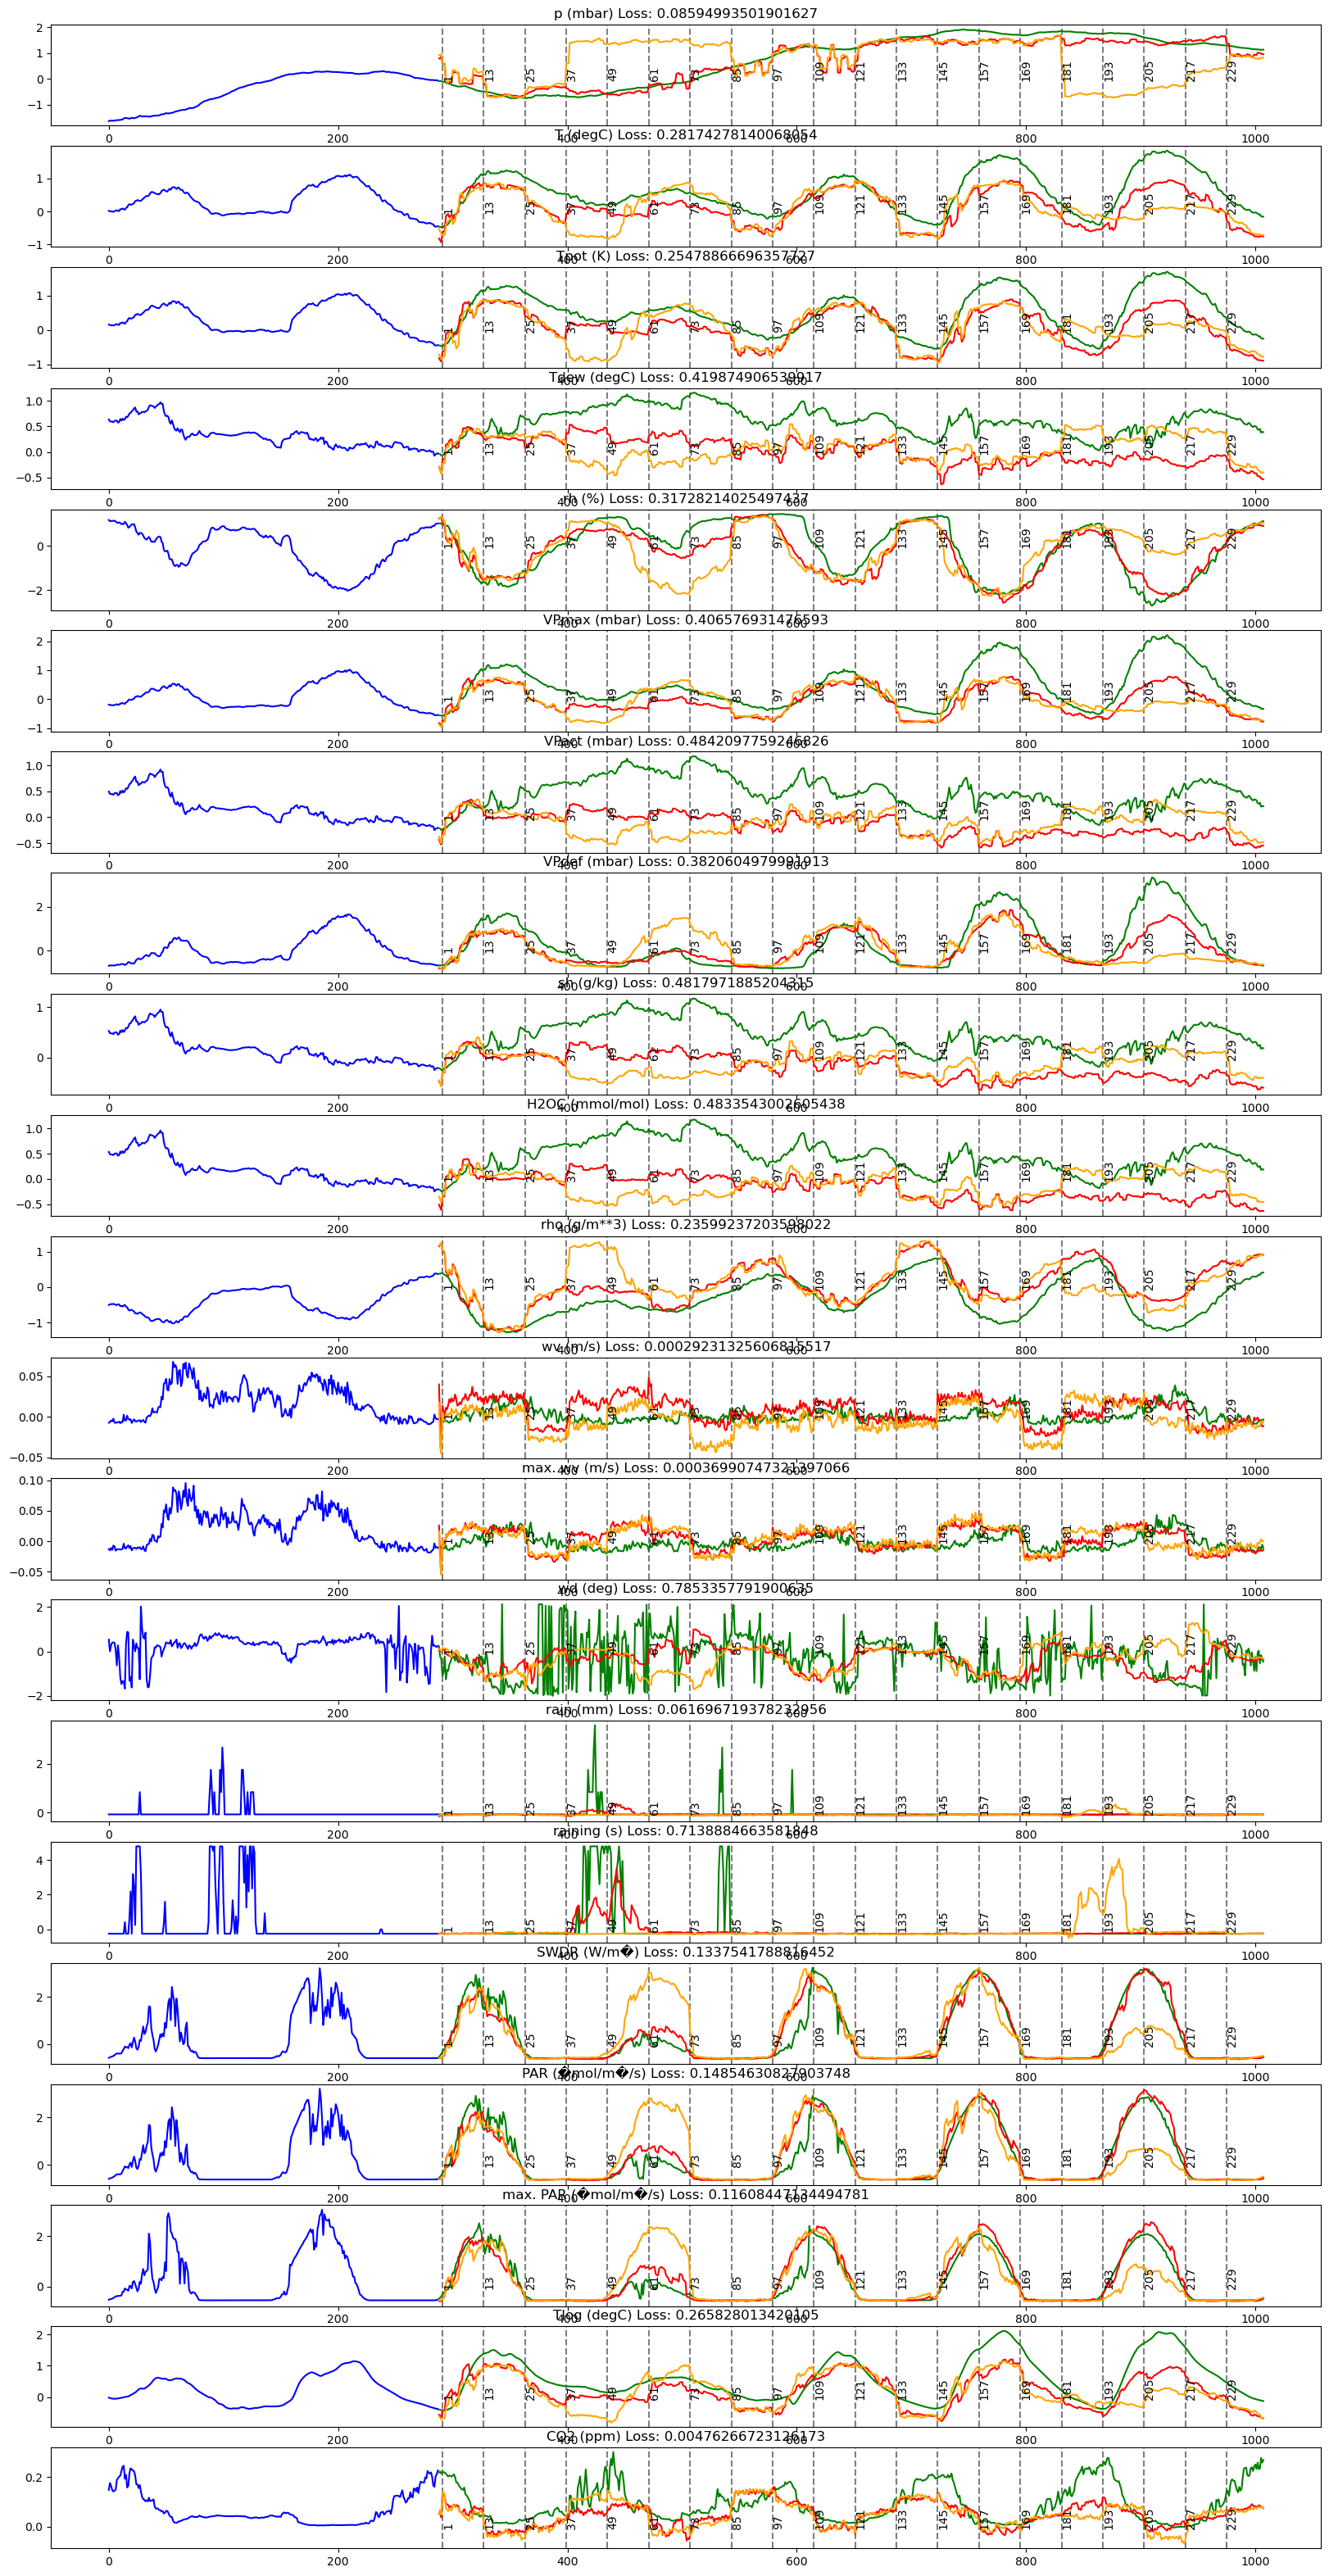

In [33]:


controlled_outputs = model(batch_x, batch_news, batch_des, news_mask)

controlled_preds = controlled_outputs.detach().cpu()
trues = batch_y.detach()
inputs = batch_x.detach().cpu()

# create a figure with (12, 2) subplots
fig, axs = plt.subplots(21, 1, figsize=(20, 40))

cols=test_data.cols[-controlled_outputs.shape[2]:]

change_points=[]

for i in range(batch_news.shape[1]-1):
    if (batch_news[0][i+1][0]-batch_news[0][i][0]).sum() != 0:
        change_points.append(i+1)

for dim in range(controlled_outputs.shape[2]):
    pred = preds[0, -config.pred_len:, dim]
    true = trues[0, -config.pred_len:, dim]
    controlled_pred = controlled_preds[0, :, dim]
    input = inputs[0, :, dim]

    loss = criterion(pred, true)

    # select subplot 3
    for change_point in change_points:
        axs[dim].axvline(x=change_point*3+288, color='grey', linestyle='--')
        # add the change_point as a text aside the axvline
        axs[dim].text(change_point*3+288, 0, f'{change_point}', rotation=90)

    # plot the concatenated input, prediction and true values
    axs[dim].plot(np.arange(len(input)), input, label='input', color='blue')
    axs[dim].plot(np.arange(len(input), len(input) + len(true)), true, label='true', color='green')
    axs[dim].plot(np.arange(len(input), len(input) + len(pred)), pred, label='pred', color='red')
    axs[dim].plot(np.arange(len(input), len(input) + len(pred)), controlled_pred, label='controlled pred', color='orange')
    axs[dim].set_title(f'{cols[dim]} Loss: {loss.item()}')

    


# show the plot
plt.show()

In [37]:
# get the timestamp of a segment
time_stamp=time_stamps[37]
date = str(time_stamp)[:8]
time = int(str(time_stamp)[8:])
if time<=559:
    time_stamp=date+'0000'
elif time<=1159:
    time_stamp=date+'0600'
elif time<=1759:
    time_stamp=date+'1200'
else:
    time_stamp=date+'1800'


tgt_time_stamp = time_stamp

trans[test_data.time2msg[1][tgt_time_stamp]]

(["It's the early morning of a day in April.",
  'The current weather is light rain with clear patches. ',
  'Clear skies will give way to light rain and partly cloudy conditions. ',
  'The temperature is mostly steady with a slight decrease towards the end. ',
  'There is a Light Breeze coming from the North, shifting to North-northwest. ',
  'The atmospheric pressure is average. ',
  'The air is very humid.'],
 [tensor([ 5.0198e-02, -1.0694e-03, -2.2782e-03, -1.5549e-03, -7.9189e-02,
           2.3601e-02,  3.1781e-02,  6.3210e-02,  1.7506e-02,  2.9725e-02,
           3.3955e-02,  7.7838e-02,  2.5731e-02,  2.3234e-02, -4.3986e-03,
           2.2456e-02, -5.8423e-02,  4.0887e-02, -6.4561e-02, -2.2720e-02,
           2.5811e-03,  9.0997e-02, -7.2492e-02,  4.9464e-02,  1.3644e-02,
           5.9069e-02,  1.1661e-02, -2.6527e-03,  2.2088e-02,  5.0345e-02,
          -1.6008e-02,  5.6278e-02,  9.9456e-02, -9.4727e-03, -3.0959e-02,
           4.5704e-02, -4.2091e-02,  8.1128e-02,  5.2254e-0

In [36]:
tgt_time_stamp = '201804160000'

trans[test_data.time2msg[1][tgt_time_stamp]]

(["It's the early morning of a day in April.",
  'The current weather is light rain with clear patches. ',
  'Clear skies will give way to light rain and partly cloudy conditions. ',
  'The temperature is mostly steady with a slight decrease towards the end. ',
  'There is a Light Breeze coming from the North, shifting to North-northwest. ',
  'The atmospheric pressure is average. ',
  'The air is very humid.'],
 [tensor([ 5.0198e-02, -1.0694e-03, -2.2782e-03, -1.5549e-03, -7.9189e-02,
           2.3601e-02,  3.1781e-02,  6.3210e-02,  1.7506e-02,  2.9725e-02,
           3.3955e-02,  7.7838e-02,  2.5731e-02,  2.3234e-02, -4.3986e-03,
           2.2456e-02, -5.8423e-02,  4.0887e-02, -6.4561e-02, -2.2720e-02,
           2.5811e-03,  9.0997e-02, -7.2492e-02,  4.9464e-02,  1.3644e-02,
           5.9069e-02,  1.1661e-02, -2.6527e-03,  2.2088e-02,  5.0345e-02,
          -1.6008e-02,  5.6278e-02,  9.9456e-02, -9.4727e-03, -3.0959e-02,
           4.5704e-02, -4.2091e-02,  8.1128e-02,  5.2254e-0